In [9]:
import sys
sys.path.insert(0, "/Users/aninauldum/Documents/Datalogi/bachelor/BA/hyperiax_internal_data/")
import hyperiax

In [10]:
import numpy as np
from matplotlib import cm
from matplotlib.colors import to_hex
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from functools import lru_cache
from hyperiax.tree import HypTree, TopologyNode
from matplotlib.transforms import Bbox
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from scipy.interpolate import CubicSpline

In [11]:
def get_path_root_to_leaf(leaf):
    path = [leaf]
    while path[-1].parent is not None:
        path.append(path[-1].parent)
    return path[::-1]  

In [12]:
with open("small_tree.pkl", "rb") as f:
    tree = pickle.load(f)

#with open("big_tree.pkl", "rb") as f:
#    tree = pickle.load(f)

In [17]:
from functools import lru_cache
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from matplotlib.colors import to_hex


def animate_tree_and_shape(tree, tip_index=0, n_total_frames=100, mode='2PC+Time'):
    leaf = list(tree.iter_topology_leaves_bfs())[tip_index]
    path = get_path_root_to_leaf(leaf)

    def format_name(name):
        return name.replace("_", " ").title()

    def safe_last(data):
        return data if data.ndim == 1 else data[-1]

    @lru_cache(None)
    def get_shape_value(node_id):
        return safe_last(tree.data['value'][node_id]).reshape(-1, 2)

    @lru_cache(None)
    def get_projected_coord(node_id):
        pc = safe_last(tree.data['projected_value'][node_id])
        if mode == '3PC':
            return pc[:3]
        elif mode == '2PC+Time':
            z = depths[node_id]
            return np.array([pc[0], pc[1], z])
        raise ValueError(f"Unknown mode: {mode}")

    depths = {
        node.id: tree.data['cum_sum_edge_length'][node.id][0]
        for node in tree.iter_topology_bfs()
    }

    # ---- Interpolation Setup ----
    times = [depths[path[i + 1].id] - depths[path[i].id] for i in range(len(path) - 1)]
    total_time = sum(times)
    weights = [t / total_time for t in times]
    cumulative_dist = np.concatenate([[0.0], np.cumsum(weights)])

    interp_steps = np.linspace(0, 1, n_total_frames)

    def interpolate_along_path():
         shapes, coords = [], []
         for s in interp_steps:
             for i, (d0, d1) in enumerate(zip(cumulative_dist[:-1], cumulative_dist[1:])):
                 if d0 <= s <= d1:
                     alpha = (s - d0) / (d1 - d0)
                     p, c = path[i], path[i + 1]
                     shape = (1 - alpha) * get_shape_value(p.id) + alpha * get_shape_value(c.id)
                     coord = (1 - alpha) * get_projected_coord(p.id) + alpha * get_projected_coord(c.id)
                     shapes.append(shape)
                     coords.append(coord)
                     break
             else:
                 shapes.append(get_shape_value(path[-1].id))
                 coords.append(get_projected_coord(path[-1].id))
         return shapes, coords

    interpolated_shapes, interpolated_path = interpolate_along_path()

    # ---- Setup Colors ----
    unique_levels = sorted({int(tree.data['level'][node.id][0]) for node in tree.iter_topology_dfs()})
    level_colors = {lvl: to_hex(cm.cool(lvl / max(unique_levels))) for lvl in unique_levels}

    # ---- Plot Setup ----
    fig = plt.figure(figsize=(12, 6))
    ax_tree = fig.add_subplot(121, projection='3d')
    ax_shape = fig.add_subplot(122)
    fig.suptitle(f"{format_name(leaf.name) if leaf.name else 'Unknown Butterfly'} ({mode})", fontsize=16)

    ax_tree.set_title("Morphospace Tree")
    ax_shape.set_title("Evolving Shape")
    morph_label = ax_shape.text(0.5, -0.1, "", fontsize=10, ha='center', transform=ax_shape.transAxes)

    all_coords = np.array([get_projected_coord(node.id) for node in tree.iter_topology_dfs()])
    margin = (all_coords.max(0) - all_coords.min(0)) * 0.1
    for dim, setter in zip(range(3), [ax_tree.set_xlim, ax_tree.set_ylim, ax_tree.set_zlim]):
        setter(all_coords[:, dim].min() - margin[dim], all_coords[:, dim].max() + margin[dim])

    for node in tree.iter_topology_dfs():
        coord = get_projected_coord(node.id)
        ax_tree.scatter(*coord, color='plum', s=5)
        if node.parent:
            p_coord = get_projected_coord(node.parent.id)
            ax_tree.plot([p_coord[0], coord[0]], [p_coord[1], coord[1]], [p_coord[2], coord[2]],
                         color='plum', linewidth=1, alpha=0.5)

    red_dot = ax_tree.scatter([], [], [], color='red', s=40)

    ax_shape.set_aspect('equal')
    ax_shape.axis('off')
    sc = ax_shape.scatter([], [], s=10, color='royalblue')
    line, = ax_shape.plot([], [], color='cornflowerblue', linewidth=1)

    all_shapes = np.vstack(interpolated_shapes)
    ax_shape.set_xlim(all_shapes[:, 0].min() - 0.1 * all_shapes[:, 0].ptp(),
                      all_shapes[:, 0].max() + 0.1 * all_shapes[:, 0].ptp())
    ax_shape.set_ylim(all_shapes[:, 1].min() - 0.1 * all_shapes[:, 1].ptp(),
                      all_shapes[:, 1].max() + 0.1 * all_shapes[:, 1].ptp())
    ax_shape.invert_yaxis()

    branch_lines, node_scatters, revealed_nodes = [], [], set()

    def init():
        red_dot._offsets3d = ([], [], [])
        sc.set_offsets(np.zeros_like(interpolated_shapes[0]))
        line.set_data([], [])
        root = path[0]
        coord = get_projected_coord(root.id)
        node_scatters.append(ax_tree.scatter(*coord, color='black', s=10))
        revealed_nodes.add(root.id)
        return sc, line, red_dot, *node_scatters, *branch_lines

    def reveal_nodes_at_level(level):
        for node in tree.iter_topology_dfs():
            if int(tree.data['level'][node.id][0]) == level and node.id not in revealed_nodes:
                color = level_colors.get(level, 'magenta')
                coord = get_projected_coord(node.id)
                node_scatters.append(ax_tree.scatter(*coord, color=color, s=10))
                if node.parent:
                    p_coord = get_projected_coord(node.parent.id)
                    branch_lines.append(ax_tree.plot(
                        [p_coord[0], coord[0]], [p_coord[1], coord[1]], [p_coord[2], coord[2]],
                        color=color, linewidth=2
                    )[0])
                revealed_nodes.add(node.id)

    def update(frame):
        shape = interpolated_shapes[frame]
        sc.set_offsets(shape)
        x, y = np.append(shape[:, 0], shape[0, 0]), np.append(shape[:, 1], shape[0, 1])
        line.set_data(x, y)

        pos = interpolated_path[frame]
        red_dot._offsets3d = ([pos[0]], [pos[1]], [pos[2]])

        # Determine current node by position along the path
        s = frame / n_total_frames
        for i in range(len(cumulative_dist) - 1):
            if cumulative_dist[i] <= s < cumulative_dist[i + 1]:
                current_node = path[i + 1]
                break
        else:
            current_node = path[-1]

        level = int(tree.data['level'][current_node.id][0])
        reveal_nodes_at_level(level)

        if current_node.name:
            morph_label.set_text(f"Morph: {format_name(current_node.name)}")

        return sc, line, red_dot, *node_scatters, *branch_lines

    ani = animation.FuncAnimation(fig, update, init_func=init,
                                  frames=n_total_frames, blit=True, interval=50)

    for level in unique_levels:
        ax_tree.scatter([], [], [], color=level_colors[level], label=f'Level {level + 1}')
    ax_tree.legend(loc='upper left', fontsize='small')

    return ani


Saved animation to butterfly_animation.html


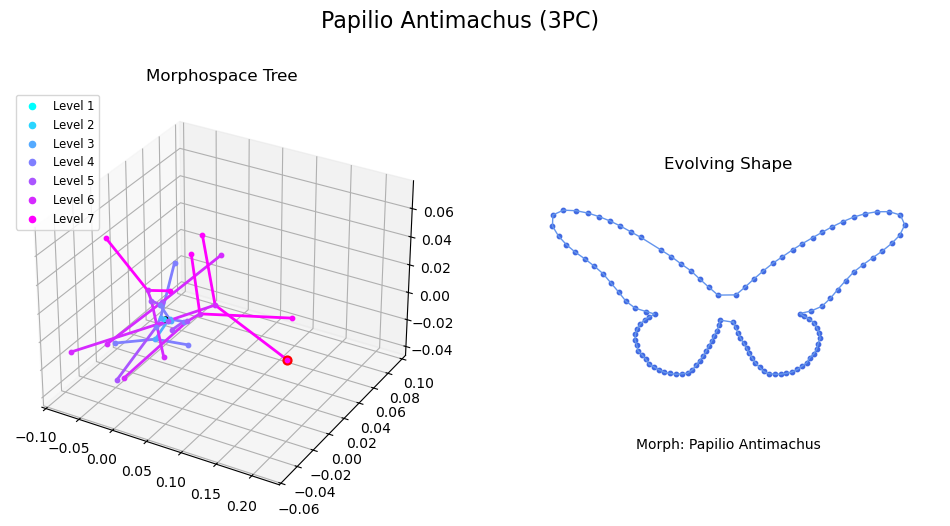

In [19]:

# Setup dropdown options
leaf_nodes = list(tree.iter_topology_leaves_bfs())
tip_options = [("Select a butterfly", -1)] + [
    (node.name.replace('_', ' ').title(), i) for i, node in enumerate(leaf_nodes)
]

mode_options = [("3D PCA (3PC)", "3PC"), ("2D PCA + Time (2PC+Time)", "2PC+Time")]

# Widgets
dropdown_tip = widgets.Dropdown(
    options=tip_options,
    description='Butterfly:',
    layout=widgets.Layout(width='50%')
)

dropdown_mode = widgets.Dropdown(
    options=mode_options,
    value="3PC",
    description='Mode:',
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()
loading_label = widgets.Label(value='')

# Cache rendered animations by tip index + mode
@lru_cache(maxsize=20)
def get_animation_html(tip_index, mode):
    if tip_index == -1:
        return ""
    ani = animate_tree_and_shape(tree, tip_index=tip_index, n_total_frames=100, mode=mode)
    html = ani.to_jshtml()
    plt.close()
    return html

def render_animation(tip_index, mode):
    if tip_index == -1:
        loading_label.value = ""
        with output:
            clear_output(wait=True)
            display(HTML("<h3>Select a butterfly to view the animation</h3>"))
        return

    loading_label.value = "Rendering animation..."
    with output:
        clear_output(wait=True)
        html = get_animation_html(tip_index, mode)
        display(HTML(html))
    loading_label.value = ""

def on_widget_change(change):
    # Re-render when either dropdown changes
    tip_index = dropdown_tip.value
    mode = dropdown_mode.value
    render_animation(tip_index, mode)

# Observe changes
dropdown_tip.observe(on_widget_change, names='value')
dropdown_mode.observe(on_widget_change, names='value')

# Display all widgets
ui = widgets.VBox([widgets.HBox([dropdown_tip, dropdown_mode]), loading_label, output])
display(ui)

if __name__ == "__main__":
    tip_index = 12  # Set this to the butterfly index you want to export
    mode = "3PC"

    ani = animate_tree_and_shape(tree, tip_index=tip_index, n_total_frames=100, mode=mode)
    html = ani.to_jshtml()

    with open("butterfly_animation.html", "w") as f:
        f.write(html)

    print("Saved animation to butterfly_animation.html")


In [15]:
def animate_tip_highlight_with_shape(tree: HypTree, frames_per_tip=1):
    from matplotlib import pyplot as plt
    from matplotlib import animation
    import numpy as np

    def format_name(name):
        return name.replace("_", " ").title() if name else "Unknown Butterfly"

    def safe_last(data):
        return data if len(data.shape) == 1 else data[-1]

    def get_projected_coord(node_id):
        return safe_last(tree.data['projected_value'][node_id])[:3]

    def get_shape_value(node_id):
        return safe_last(tree.data['value'][node_id]).reshape(-1, 2)

    tip_nodes = list(tree.iter_topology_leaves_bfs())
    tip_coords = [get_projected_coord(tip.id) for tip in tip_nodes]
    tip_shapes = [get_shape_value(tip.id) for tip in tip_nodes]

    fig = plt.figure(figsize=(12, 6))
    ax_tree = fig.add_subplot(121, projection='3d')
    ax_shape = fig.add_subplot(122)
    fig.suptitle("Tip Morphospace Viewer", fontsize=14, fontweight='bold')

    # Setup PCA morphospace limits
    all_coords = np.array([get_projected_coord(node.id) for node in tree.iter_topology_dfs()])
    margin = (all_coords.max(axis=0) - all_coords.min(axis=0)) * 0.1
    for dim, setter in zip(range(3), [ax_tree.set_xlim, ax_tree.set_ylim, ax_tree.set_zlim]):
        setter(all_coords[:, dim].min() - margin[dim], all_coords[:, dim].max() + margin[dim])

    ax_tree.set_title("PCA Morphospace")
    ax_shape.set_title("Butterfly Shape")
    ax_shape.set_aspect('equal')
    ax_shape.axis('off')

    # Draw all static nodes and edges in plum just once
    for node in tree.iter_topology_dfs():
        coord = get_projected_coord(node.id)
        ax_tree.scatter(*coord, color='plum', s=5)
        if node.parent:
            parent_coord = get_projected_coord(node.parent.id)
            ax_tree.plot(
                [coord[0], parent_coord[0]],
                [coord[1], parent_coord[1]],
                [coord[2], parent_coord[2]],
                color='plum',
                linewidth=1,
                alpha=0.5
            )

    # Dynamic elements
    red_dot = ax_tree.scatter([], [], [], color='red', s=40)
    sc = ax_shape.scatter([], [], s=10, color='royalblue')
    line, = ax_shape.plot([], [], color='cornflowerblue', linewidth=1)
    morph_label = ax_shape.text(0.5, -0.1, "", fontsize=10, ha='center', va='top', transform=ax_shape.transAxes)

    # Shape axis limits
    all_shapes = np.vstack(tip_shapes)
    x_margin = all_shapes[:, 0].ptp() * 0.1
    y_margin = all_shapes[:, 1].ptp() * 0.1
    ax_shape.set_xlim(all_shapes[:, 0].min() - x_margin, all_shapes[:, 0].max() + x_margin)
    ax_shape.set_ylim(all_shapes[:, 1].min() - y_margin, all_shapes[:, 1].max() + y_margin)
    ax_shape.invert_yaxis()

    total_frames = len(tip_nodes) * frames_per_tip

    def init():
        red_dot._offsets3d = ([], [], [])
        sc.set_offsets(np.zeros((0, 2)))
        line.set_data([], [])
        morph_label.set_text("")
        return sc, line, red_dot, morph_label

    def update(frame):
        tip_index = frame // frames_per_tip
        coord = tip_coords[tip_index]
        shape = tip_shapes[tip_index]
        name = tip_nodes[tip_index].name

        red_dot._offsets3d = ([coord[0]], [coord[1]], [coord[2]])
        sc.set_offsets(shape)
        x = np.append(shape[:, 0], shape[0, 0])
        y = np.append(shape[:, 1], shape[0, 1])
        line.set_data(x, y)
        morph_label.set_text(format_name(name))
        return sc, line, red_dot, morph_label

    ani = animation.FuncAnimation(
        fig, update, init_func=init,
        frames=total_frames, interval=150, blit=True
    )

    return ani


In [ ]:
#tips = animate_tip_highlight_with_shape(tree)
#HTML(tips.to_jshtml())